In [ ]:
import seaborn as sns

In [1]:
import os
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

def get_youtube_comments(video_id, api_key):
    youtube = build('youtube', 'v3', developerKey=api_key)
    
    # Get comments from the video
    comments = []
    results = youtube.commentThreads().list(
        part="snippet",
        videoId=video_id,
        textFormat="plainText",
        maxResults=100  # Adjust as needed
    ).execute()

    while results:
        print(f"parse {len(results)} buckets of results.")
        for item in results['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            comments.append(comment)        
        # Check if there are more comments
        if 'nextPageToken' in results:
            try:
                results = youtube.commentThreads().list(
                    part="snippet",
                    videoId=video_id,
                    textFormat="plainText",
                    maxResults=100,
                    pageToken=results['nextPageToken']
                ).execute()
            except HttpError as e:
                print(f'An HTTP error {e.resp.status} occurred: {e.content}')
                return comments
        else:
            break
    return comments

In [2]:
from pathlib import Path
import pandas as pd

path_csv = Path("comments.csv.zip")

if path_csv.exists():
    print(f"Loading cached {path_csv}")
    df = pd.read_csv(path_csv)
else:    
    print(f"Could not find cached {path_csv}, regenerating it")
    video_id = "VOc44fVvneI" 
    api_key = os.getenv("YT_KEY")
    comments = get_youtube_comments(video_id, api_key)
    print(f"Parsed {len(comments)} comments.")
    rows = []
    for comment in comments:
        rows.append({
            "textOriginal": comment['textOriginal'],
            "authorDisplayName": comment['authorDisplayName'],
            "likeCount": comment['likeCount'],
            "publishedAt": comment['publishedAt'],
        })
    df = pd.DataFrame(rows)
    df.sort_values(by="publishedAt", inplace=True)
    df.reset_index(inplace=True, drop=True)
    df.to_csv(path_csv, index=False)

print(f"Loaded {len(df)} comments.")

Loading cached comments.csv.zip
Loaded 1242 comments.


In [3]:
df.head()

,Unnamed: 0,textOriginal,authorDisplayName,likeCount,publishedAt
0,0,The Coup Has Already Happened - and Democrats ...,@Localemediea,0,2025-02-14T14:47:06Z
1,1,"With the kind of money these ""unelected bureau...",@gh00stbeard,0,2025-02-14T14:48:55Z
2,2,DENAZ-IFICATION of the OLD WORLD Narratives ak...,@ZIGZAGroundZERO,1,2025-02-14T14:49:25Z
3,3,U.S. Vice President JD Vance has taken the sta...,@cashaeleatemla,0,2025-02-14T14:49:29Z
4,4,Vice President JD Vance accused European leade...,@cashaeleatemla,0,2025-02-14T14:50:01Z


In [4]:
df.sort_values(by="likeCount")

,Unnamed: 0,textOriginal,authorDisplayName,likeCount,publishedAt
0,0,The Coup Has Already Happened - and Democrats ...,@Localemediea,0,2025-02-14T14:47:06Z
723,723,❤❤❤That is as direct as it gets and on point! ...,@Judy-v5r,0,2025-02-14T18:21:56Z
724,724,Great speech 👏👏👏the munich security conference...,@Nazanin49,0,2025-02-14T18:25:08Z
725,725,"The this oozes with lies, irony & hypocrisy. V...",@antonanon,0,2025-02-14T18:25:47Z
726,726,Excellent.❤,@suzum.9713,0,2025-02-14T18:26:29Z
...,...,...,...,...,...
327,327,Never saw Kamala speak or do anything as VP.,@ReefHausDynamics,351,2025-02-14T15:54:59Z
869,869,I am blown away with this monumental speech by...,@aleksandrmelikov308,363,2025-02-14T21:58:21Z
24,24,Oh wow a human being. Someone capable of strin...,@thomasschimmeyer8715,381,2025-02-14T14:53:35Z
692,692,I’m German. This is one of the greatest speech...,@Habibilehm,478,2025-02-14T17:56:13Z


In [5]:
print(df.textOriginal.tolist()[418])

From France, thank you. Powerful and inspiring speech that I've been dreaming to hear in French for decades. Our political elite is rotten to the core. It feels great to have someone too powerful to be silenced by them, saying the truth out loud. Vive la liberté.


In [6]:
# We can do the same thing with a SQLite cache
from langchain_community.cache import SQLiteCache
from langchain_core.globals import set_llm_cache
from langchain_core.prompts import ChatPromptTemplate
from langchain_together import ChatTogether
set_llm_cache(SQLiteCache(database_path=".langchain.db"))
llm_model = "meta-llama/Llama-3.3-70B-Instruct-Turbo"
chat_model = ChatTogether(model=llm_model)


In [7]:
system_template = "You are a smart assistant helping to categorize Youtube comments."
comment = df.textOriginal.tolist()[418]
raw_prompt = '''\
Given the following comment, output a JSON containing a single field "sentiment" that should be either "positive", "neutral", negative".
The "sentiment" should be based on the comment and indicate the sentiment toward the speech and JD Vance.

Here are a few examples, 
* He is Sickening => {{"sentiment": "negative"}}
* With the kind of money these "unelected bureaucrats" are stealing from Americans? Yes! Worry about the threat WITHIN!!!😡😡😡 => {{"sentiment": "positive"}}
* Did someone tell him he is the threat? => {{"sentiment": "negative"}}
* From France, thank you. Powerful and inspiring speech that I've been dreaming to hear in French for decades. Our political elite is rotten to the core. It feels great to have someone too powerful to be silenced by them, saying the truth out loud. Vive la liberté. => {{"sentiment": "positive"}}

Importantly, note that the sentiment is toward the speech and JD Vance idea, if it is supportive to the speach and in an angry tone, it should be classified as positive.
Just outputs the JSON and nothing more as your output will be parsed. Here is the comment I want you to classify:

--

{comment}

'''
prompt_template = ChatPromptTemplate.from_messages([
    ("system", system_template), 
    ("user", raw_prompt)]
)
prompt = prompt_template.invoke({"comment": comment})
print(prompt.messages[1].content)


Given the following comment, output a JSON containing a single field "sentiment" that should be either "positive", "neutral", negative".
The "sentiment" should be based on the comment and indicate the sentiment toward the speech and JD Vance.

Here are a few examples, 
* He is Sickening => {"sentiment": "negative"}
* With the kind of money these "unelected bureaucrats" are stealing from Americans? Yes! Worry about the threat WITHIN!!!😡😡😡 => {"sentiment": "positive"}
* Did someone tell him he is the threat? => {"sentiment": "negative"}
* From France, thank you. Powerful and inspiring speech that I've been dreaming to hear in French for decades. Our political elite is rotten to the core. It feels great to have someone too powerful to be silenced by them, saying the truth out loud. Vive la liberté. => {"sentiment": "positive"}

Importantly, note that the sentiment is toward the speech and JD Vance idea, if it is supportive to the speach and in an angry tone, it should be classified as pos

In [8]:
comments = df.textOriginal.tolist()

prompts = [prompt_template.invoke({"comment": comment}) for comment in comments]
results = chat_model.batch(inputs=prompts)


In [9]:
def sentiment_to_float(s: str):
    if "negative" in s:
        return -1 
    if "positive" in s:        
        return 1
    else:
        return 0
sentiments = [x.content for x in results]
sentiments = [sentiment_to_float(x.content) for x in results]

df_with_sentiment = df.copy()
df_with_sentiment["sentiment"] = sentiments
df_with_sentiment.to_csv("sentiments.csv.zip")

In [11]:
df_with_sentiment.head()

,Unnamed: 0,textOriginal,authorDisplayName,likeCount,publishedAt,sentiment
0,0,The Coup Has Already Happened - and Democrats ...,@Localemediea,0,2025-02-14T14:47:06Z,-1
1,1,"With the kind of money these ""unelected bureau...",@gh00stbeard,0,2025-02-14T14:48:55Z,1
2,2,DENAZ-IFICATION of the OLD WORLD Narratives ak...,@ZIGZAGroundZERO,1,2025-02-14T14:49:25Z,1
3,3,U.S. Vice President JD Vance has taken the sta...,@cashaeleatemla,0,2025-02-14T14:49:29Z,0
4,4,Vice President JD Vance accused European leade...,@cashaeleatemla,0,2025-02-14T14:50:01Z,0


In [162]:
xx = df_with_sentiment.loc[df_with_sentiment.likeCount == 0, "sentiment"].value_counts()
positive = xx[xx.index == 1].sum()
negative = xx[xx.index == -1].sum()
n_comments = xx[xx.index!=0].sum()
print(f"Proportion of positive sentiment for comments with 0 like(s): {positive / (positive + negative):.3f} ({n_comments} comments)")

print(f"\nProportion of positive sentiment for comments with:")
for n_likes in [1, 2, 5, 10]:
    xx = df_with_sentiment.loc[df_with_sentiment.likeCount > n_likes, "sentiment"].value_counts()
    positive = xx[xx.index == 1].sum()
    negative = xx[xx.index == -1].sum()
    n_comments = xx[xx.index!=0].sum()
    print(f"more than {n_likes} like(s): {positive / (positive + negative):.3f} ({n_comments} comments)")

Proportion of positive sentiment for comments with 0 like(s): 0.578 (552 comments)

Proportion of positive sentiment for comments with:
more than 1 like(s): 0.885 (384 comments)
more than 2 like(s): 0.915 (307 comments)
more than 5 like(s): 0.963 (215 comments)
more than 10 like(s): 0.994 (168 comments)


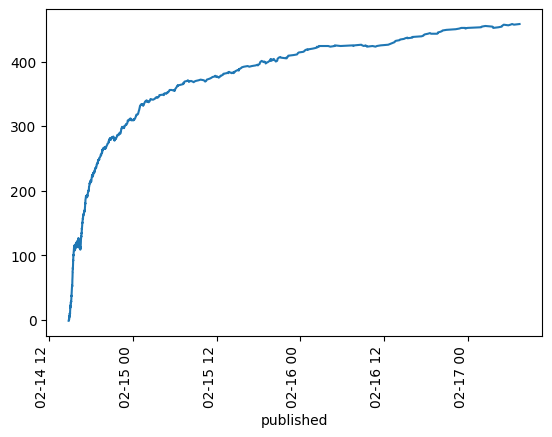

In [163]:
#df_with_sentiment.publishedAt = pd.to_datetime(df_with_sentiment.publishedAt)
df_with_sentiment["published"] = pd.to_datetime(df_with_sentiment.publishedAt)
ax = df_with_sentiment.set_index("published").sentiment.cumsum().plot()
ax.tick_params(axis='x', rotation=90)

In [164]:
df_with_sentiment.head()

,Unnamed: 0,textOriginal,authorDisplayName,likeCount,publishedAt,sentiment,published
0,0,The Coup Has Already Happened - and Democrats ...,@Localemediea,0,2025-02-14T14:47:06Z,-1,2025-02-14 14:47:06+00:00
1,1,"With the kind of money these ""unelected bureau...",@gh00stbeard,0,2025-02-14T14:48:55Z,1,2025-02-14 14:48:55+00:00
2,2,DENAZ-IFICATION of the OLD WORLD Narratives ak...,@ZIGZAGroundZERO,1,2025-02-14T14:49:25Z,1,2025-02-14 14:49:25+00:00
3,3,U.S. Vice President JD Vance has taken the sta...,@cashaeleatemla,0,2025-02-14T14:49:29Z,0,2025-02-14 14:49:29+00:00
4,4,Vice President JD Vance accused European leade...,@cashaeleatemla,0,2025-02-14T14:50:01Z,0,2025-02-14 14:50:01+00:00


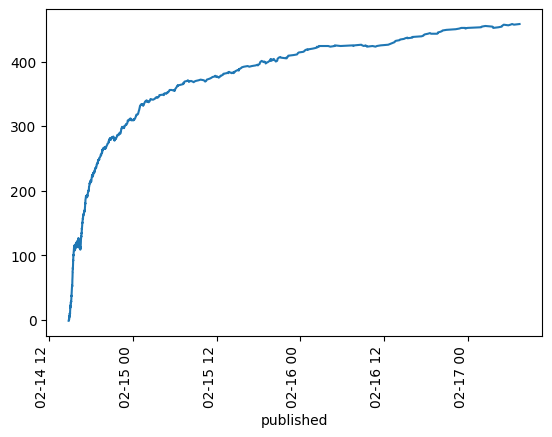

In [165]:
#df_with_sentiment.publishedAt = pd.to_datetime(df_with_sentiment.publishedAt)
df_with_sentiment["published"] = pd.to_datetime(df_with_sentiment.publishedAt)
ax = df_with_sentiment.set_index("published").sentiment.cumsum().plot()
ax.tick_params(axis='x', rotation=90)

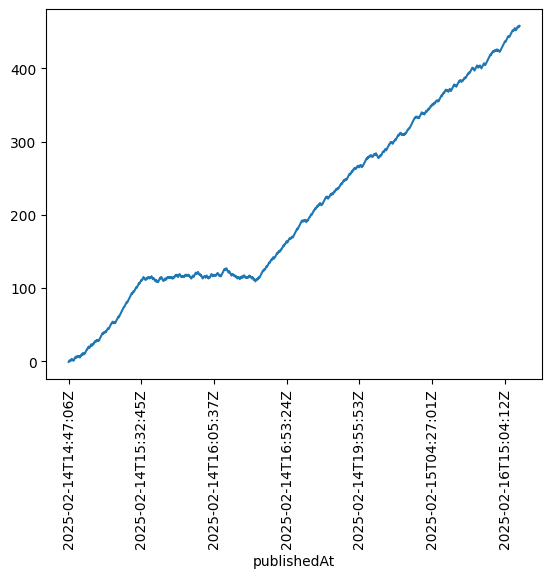

In [166]:
#df_with_sentiment.publishedAt = pd.to_datetime(df_with_sentiment.publishedAt)
ax = df_with_sentiment.set_index("publishedAt").sentiment.cumsum().plot()
ax.tick_params(axis='x', rotation=90)